In [1]:
# lad-based-film-transformation

In [2]:
import altair
import cv2
import matplotlib.pylab as plt
import numpy
import pandas
import pathlib
import scipy
import skimage
import subprocess
import warnings

In [3]:
def patch_region(n, d):

    ''' Identify patch regions. '''

    regions = list()
    for i in range(n):
        x = (i)*(d['w']+d['d'])+d['x']
        regions.append([x,d['y'],x+d['w'],d['y']+d['h']])
    return regions

def extract_patch(a, i):

    ''' Extract rgb values from image section. '''

    section = i[a[1]:a[3],a[0]:a[2]]
    r = numpy.mean(numpy.ravel(section[:,:,:1]))
    g = numpy.mean(numpy.ravel(section[:,:,1:2]))
    b = numpy.mean(numpy.ravel(section[:,:,2:3]))
    return ([r,g,b])

def patch_values(location, image):

    ''' Reorder rgb values for plotting. '''

    p = [extract_patch(a, image) for a in location]
    p = [[y[x] for y in p] for x in range(len(p[0]))]
    patch_dict = {x:p[n] for n, x in enumerate(['r', 'g', 'b'])}
    return patch_dict

def plot_values(data):

    ''' Plot patch mean values as line graph. '''

    warnings.simplefilter(action='ignore', category=FutureWarning)
    data = pandas.melt(pandas.DataFrame(data)).rename(columns={'variable':'channel'})
    data['patch'] = [x%6 for x in range(len(data))]
    chart = altair.Chart(data).mark_line().encode(x='patch:N', y='value',
        color=altair.Color('channel:N', scale=altair.Scale(domain=['r', 'g', 'b'], range=['#c44240', '#40a368', '#2976bb'])))
    display(altair.layer(chart).properties(width=550, height=400, title=''))

def render_image(i):

    ''' Render image to notebook. '''

    print(i.shape)
    plt.figure(figsize=(7.5,7.5))
    plt.imshow(skimage.img_as_float32(i))
    plt.show()  

(3956, 4300, 3)


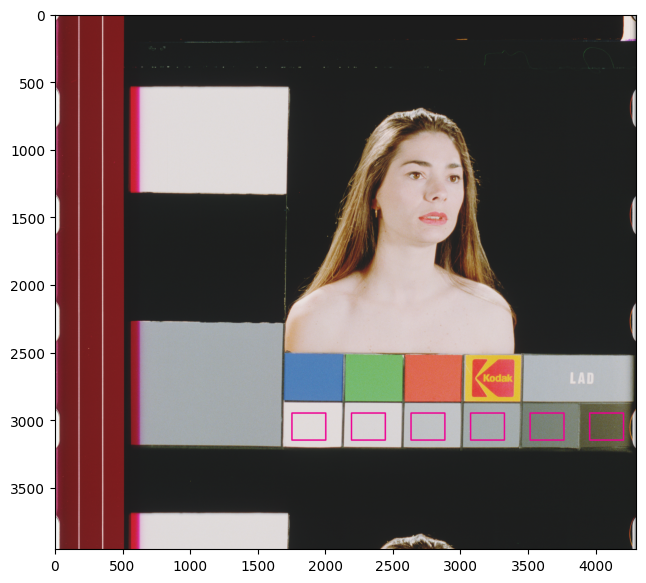

In [4]:
# reference frame with density patches.

ref_path = pathlib.Path.cwd() / '0087124.tif'
img = cv2.cvtColor(cv2.imread(str(ref_path), -1), cv2.COLOR_BGR2RGB) 
regions = patch_region(6, {'x': 1750, 'y': 2950, 'w':250, 'h':200, 'd':190})
for i in regions:
    cv2.rectangle(img, (i[0], i[1]), (i[2],i[3]), (2**15.9,2**1,2**15.2), 10)

render_image(img) 

In [5]:
# source mean patch values.

img = cv2.cvtColor(cv2.imread(str(ref_path), -1), cv2.COLOR_BGR2RGB) 
means = patch_values(regions, img)
plot_values(means) 

alt.LayerChart(...)

In [6]:
# generate lut from interpolating source values to aim distribution.

aims = [100]+[(x*((0.9-0.05)/5)+0.05)*(2**16) for x in range(6)]+[(2**16)-100]
img = cv2.cvtColor(cv2.imread(str(ref_path), -1), cv2.COLOR_BGR2RGB) 
means = patch_values(regions, img)

rgb_values = dict()

for n, x in enumerate(['r', 'g', 'b']):
    mean_full = [100]+means[x][::-1]+[(2**16)-100]
    f = scipy.interpolate.PchipInterpolator(mean_full, aims, extrapolate=True)
    rgb_values[x] = [float(f(i*((2**16)/1024)))/(2**16) for i in range(1024)]

rgb_ordered = zip(rgb_values['r'], rgb_values['g'], rgb_values['b'])

lut_path = ref_path.parents[0] / f'{ref_path.stem}.cube'
with open(lut_path, 'w') as lut_data:
    lut_data.write('LUT_1D_SIZE 1024\n')
    lut_data.write('LUT_1D_INPUT_RANGE 0.0 1.0\n')
    for i in rgb_ordered:
        lut_data.write(' '.join(['%.6f' % x for x in i])+'\n')

In [7]:
# render source file to target via lut.

render_path = pathlib.Path.cwd() / 'render.tif'
call = ['ffmpeg', '-y', '-i', str(ref_path), '-vf', f'lut1d=file={str(lut_path)}', str(render_path)]
subprocess.call(call, stderr=subprocess.DEVNULL, stdout=subprocess.DEVNULL)

0

(3956, 4300, 3)


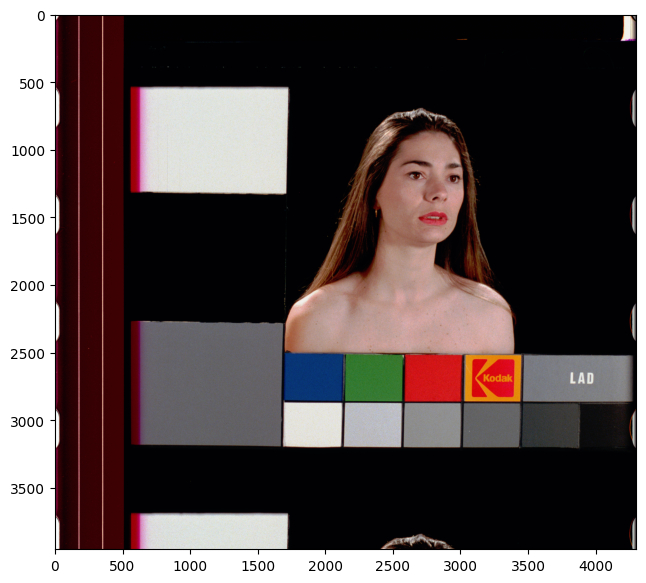

In [8]:
# rendered frame.

img2 = cv2.cvtColor(cv2.imread(str(render_path), -1), cv2.COLOR_BGR2RGB) 
render_image(img2) 

In [9]:
# rendered mean patch values.

img2 = cv2.cvtColor(cv2.imread(str(render_path), -1), cv2.COLOR_BGR2RGB) 
means = patch_values(regions, img2)
plot_values(means) 

alt.LayerChart(...)